# Trabalho prático da disciplina de aprendizado de máquina 2020-01
## Instituto de computação da Universidade Federal Fluminense
### Professora: Flávia Bernardini
### Alunos: João Ricardo Weissmann Santos e Bruna Toledo

## Importando bibliotecas

In [1]:
%matplotlib inline
%lsmagic

import time
import math

import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler

from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn import svm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import LeaveOneOut

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor

import xgboost as xgb

## Definindo funções úteis

In [2]:
def graficos_boxplot(X, colunas=None, grupo=None, restricoes=None):
    
    if grupo == None:
        print ('nenhum grupo informado')
        return None
    
    if colunas == None: colunas = X.columns.tolist()
    
    dado = X[colunas + [grupo]].copy()
    
    for col in colunas:
        plt.figure(figsize=(16, 4))
        ax = sns.boxplot(x=grupo, y=col, data=dado)
        plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
        plt.xticks(rotation=45)
    return

def detectar_outliers(X, colunas=None, metodo='one class svm', contamination=0.1):
    
    if colunas == None: colunas = X.columns.tolist()
    
    x_local = X[colunas].copy()
    
    col_num = x_local.select_dtypes(include = ['float64', 'int64']).columns.tolist()
    col_cat = x_local.select_dtypes(include = ['object']).columns.tolist()
    
    for col in col_cat:
        enc = LabelEncoder()
        x_local[col] = enc.fit_transform(x_local[col].astype(str))
        
    for col in col_num:
        x_local[col].fillna(0, inplace=True)
        
    x_local['is outlier'] = 0
    
    dado = x_local[colunas]
    
    isolation_forest = IsolationForest(n_estimators=100, behaviour='new', contamination=contamination)
    robust_covariance = EllipticEnvelope(contamination=contamination)
    OneClassSVM = svm.OneClassSVM(kernel='poly', degree=2, gamma=1000, tol=0.1, nu=contamination)
    local_out_factor = LocalOutlierFactor(n_neighbors=35, contamination=contamination)
    
    if metodo == 'one class svm': out = OneClassSVM
    if metodo == 'isolation forest': out = isolation_forest
    if metodo == 'robust covariance': out = robust_covariance
    if metodo == 'local outlier fraction': out = local_out_factor
    
    if metodo == 'local outlier fraction':
        dado['is outlier'] = out.fit_predict(dado)
    else:
        out.fit(dado)
        dado['is outlier'] = out.predict(dado)
    
    mask = dado[dado['is outlier'] == -1].index.tolist()
    x_local.loc[mask, 'is outlier'] = 1
    
    return x_local['is outlier']

def preencher_buracos(X, coluna, valor = None, coluna_grupo = None):
    if valor != None: 
        X[coluna].fillna(valor, inplace=True)
    elif coluna_grupo == coluna:
        X[coluna].fillna(X[coluna].mean())
    else:
        mask = X[coluna].isnull()
        replace_dict = X[coluna, coluna_grupo].groupby(coluna_grupo).mean().to_dict()[coluna]
        X.loc[mask, coluna] = X[coluna_grupo][mask].replace(replace_dict)
    return X

def normalizar_numericas(X, colunas_numericas = None):
    if colunas_numericas == None: colunas_numericas = X.columns.tolist()
    scaler = RobustScaler()
    X[colunas_numericas] = scaler.fit_transform(X[colunas_numericas])
    return X, scaler

def codificar_categoricas(X, colunas_categoricas = None):
    if colunas_categoricas == None: colunas_categoricas = X.columns.tolist()
    colunas_numericas = [x for x in X.columns.tolist() if x not in colunas_categoricas]
    enc = OneHotEncoder(handle_unknown='ignore')
    X_cat = pd.DataFrame(enc.fit_transform(X[colunas_categoricas]).toarray())
    X.reset_index(inplace=True, drop=True)
    res = pd.concat([X_cat, X[colunas_numericas]], axis=1)
    return res, enc

def fitar_modelo(modelo, X, y, X_test = None, y_test = None):
    modelo.fit(X, y)
    train_score = r2_score(y, modelo.predict(X))
    test_score = r2_score(y_test, modelo.predict(X_test))
    if X_test == None:
        return modelo, train_score
    else:
        return modelo, train_score, test_score

def importancia_das_features(X, y, colunas_numericas = None, colunas_categoricas = None, nome_variavel = ''): 
    
    x_local = X.copy()
    y_local = y.copy()
    
    if colunas_numericas != None: x_local, _ = normalizar_numericas(x_local, colunas_numericas)
    if colunas_categoricas != None:
        for col in colunas_categoricas:
            enc = LabelEncoder()
            x_local[col] = enc.fit_transform(x_local[col].astype(str))
    
    features_names = x_local.columns
    
    rf_importance = RandomForestRegressor(n_estimators=100, n_jobs=-1)
    rf_importance.fit(x_local, y_local)
    
    feature_importances = list(rf_importance.feature_importances_)
    list_tuples = zip(features_names, feature_importances)
    
    plt.figure(123)
    plt.figure(figsize=(5, 10))
    features_names_sort, feature_importances_sort = zip(*sorted(list_tuples, key=lambda x:x[1], reverse=False)[:50])
    plt.barh(range(len(feature_importances_sort)), feature_importances_sort)
    plt.yticks(np.arange(len(features_names_sort)), features_names_sort)
    plt.title('Feature Importances - ' + nome_variavel)
    plt.show()
    
    return features_names_sort, feature_importances_sort

def calcular_correlação(X, colunas_numericas=None, colunas_categoricas=None):
    
    x_local = X.copy()
    colunas = []
    
    if colunas_numericas != None:
        x_local, _ = normalizar_numericas(x_local, colunas_numericas)
        colunas = colunas + colunas_numericas
    if colunas_categoricas != None:
        colunas = colunas + colunas_categoricas
        for col in colunas_categoricas:
            enc = LabelEncoder()
            x_local[col] = enc.fit_transform(x_local[col].astype(str))
    
    correlacao = {}
    for col in colunas:
        val = x_local.drop(col, axis=1).apply(lambda x: x.corr(x_local[col]))
        correlacao[col] = val.sort_values(ascending=False)
    
    df = pd.DataFrame(correlacao)
            
    return df

def selecionar_features(X, y, y_name=None, colunas_numericas=None, colunas_categoricas=None, limite_corr=0.8, limite_importancia=0.8, quantidade=999):
    
    x_local = X.copy()
    y_local = y.copy()
    
    if colunas_numericas != None and colunas_categoricas != None:
        corr = calcular_correlação(x_local, colunas_numericas=colunas_numericas, colunas_categoricas=colunas_categoricas)
        features_names_sort, feature_importances_sort = importancia_das_features(x_local, y_local, colunas_numericas=colunas_numericas, colunas_categoricas=colunas_categoricas, nome_variavel = y_name)
    elif colunas_numericas != None and colunas_categoricas == None:
        corr = calcular_correlação(x_local, colunas_numericas=colunas_numericas)
        features_names_sort, feature_importances_sort = importancia_das_features(x_local, y_local, colunas_numericas=colunas_numericas, nome_variavel = y_name)
    elif colunas_numericas == None and colunas_categoricas != None:
        corr = calcular_correlação(x_local, colunas_categoricas=colunas_categoricas)
        features_names_sort, feature_importances_sort = importancia_das_features(x_local, y_local, colunas_categoricas=colunas_categoricas, nome_variavel = y_name)
    else:
        print ("algo errado ai meu camarada")
        return None
    
    features = corr.columns.tolist()
    features_slct = []
    count = 0
    for f, v in zip(reversed(features_names_sort), reversed(feature_importances_sort)):
        print (f, v)
        if count > quantidade: break
        add = True
        if float(v) > limite_importancia: add = False
        for f_f in features_slct:
            if v < 0.001 or abs(corr.loc[f, f_f]) > limite_corr: add = False
        if add: 
            features_slct.append(f)
            count += 1
    
    x_features_slct = x_local[features_slct]
    return x_features_slct, features_slct

def busca_aleatoria(X, y, modelo, parametros, metrica, n_folds = 10, n_iter = 200):
    
    start_time = time.time()
    
    print ("\n \n buscando melhores parâmetros...")
    
    otm_model = RandomizedSearchCV(modelo, param_distributions=parametros, n_iter=n_iter, 
                                   scoring=metrica, cv=n_folds, n_jobs=1, refit=list(metrica.keys())[0])
    otm_model.fit(X, y)
    
    melhores_parametros = otm_model.best_params_
    melhor_modelo = otm_model.best_estimator_
    
    resultados = pd.DataFrame(otm_model.cv_results_)
    resultados.sort_values(by='rank_test_'+str(list(metrica.keys())[0]), inplace=True)
    print ("melhores parâmetros encontrados")
    
    end_time = time.time()
    otm_time = (end_time - start_time) / 60
    
    best_score = otm_model.best_score_
    
    return melhor_modelo, melhores_parametros, best_score, resultados, otm_time

## Importando o dado

In [3]:
ls data/

Fat_Supply_Quantity_Data.csv      Protein_Supply_Quantity_Data.csv
Food_Supply_kcal_Data.csv         readme.txt
Food_Supply_Quantity_kg_Data.csv  Supply_Food_Data_Descriptions.csv


In [4]:
fat_df = pd.read_csv('./data/Fat_Supply_Quantity_Data.csv')

In [5]:
fat_df.head()

,Country,Alcoholic Beverages,Animal Products,Animal fats,"Aquatic Products, Other",Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,...,Vegetable Oils,Vegetables,Obesity,Undernourished,Confirmed,Deaths,Recovered,Active,Population,Unit (all except Population)
0,Afghanistan,0.0,21.6397,6.2224,0.0,8.0353,0.6859,0.0327,0.4246,6.1244,...,17.0831,0.3593,4.5,29.8,0.021411,0.000492,0.002445,0.018474,38042000.0,%
1,Albania,0.0,32.0002,3.4172,0.0,2.6734,1.6448,0.1445,0.6418,8.7428,...,9.2443,0.6503,22.3,6.2,0.033730,0.001085,0.026522,0.006123,2858000.0,%
2,Algeria,0.0,14.4175,0.8972,0.0,4.2035,1.2171,0.2008,0.5772,3.8961,...,27.3606,0.5145,26.6,3.9,0.017375,0.001309,0.009142,0.006925,43406000.0,%
3,Angola,0.0,15.3041,1.3130,0.0,6.5545,0.1539,1.4155,0.3488,11.0268,...,22.4638,0.1231,6.8,25,0.000165,0.000010,0.000054,0.000102,31427000.0,%
4,Antigua and Barbuda,0.0,27.7033,4.6686,0.0,3.2153,0.3872,1.5263,1.2177,14.3202,...,14.4436,0.2469,19.1,NaN,0.025773,0.003093,0.019588,0.003093,97000.0,%


In [6]:
protein_df = pd.read_csv('./data/Protein_Supply_Quantity_Data.csv')

In [7]:
protein_df.head()

,Country,Alcoholic Beverages,Animal Products,Animal fats,"Aquatic Products, Other",Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,...,Vegetables,Miscellaneous,Obesity,Undernourished,Confirmed,Deaths,Recovered,Active,Population,Unit (all except Population)
0,Afghanistan,0.0000,9.7523,0.0277,0.0,35.9771,0.4067,0.0647,0.5824,3.1337,...,1.1370,0.0462,4.5,29.8,0.021411,0.000492,0.002445,0.018474,38042000.0,%
1,Albania,0.1840,27.7469,0.0711,0.0,14.2331,1.8069,0.6274,1.2757,7.6582,...,3.2456,0.0544,22.3,6.2,0.033730,0.001085,0.026522,0.006123,2858000.0,%
2,Algeria,0.0323,13.8360,0.0054,0.0,26.5633,1.2916,0.6350,1.1624,3.5088,...,3.1267,0.1399,26.6,3.9,0.017375,0.001309,0.009142,0.006925,43406000.0,%
3,Angola,0.6285,15.2311,0.0277,0.0,20.3882,0.1756,5.4436,1.2754,7.6248,...,0.8133,0.0924,6.8,25,0.000165,0.000010,0.000054,0.000102,31427000.0,%
4,Antigua and Barbuda,0.1535,33.1901,0.1289,0.0,10.5108,0.4850,8.2146,1.2586,16.0670,...,1.6024,0.2947,19.1,NaN,0.025773,0.003093,0.019588,0.003093,97000.0,%


In [8]:
kcal_df = pd.read_csv('./data/Food_Supply_kcal_Data.csv')

In [9]:
kcal_df.head()

,Country,Alcoholic Beverages,Animal Products,Animal fats,"Aquatic Products, Other",Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,...,Vegetable Oils,Vegetables,Obesity,Undernourished,Confirmed,Deaths,Recovered,Active,Population,Unit (all except Population)
0,Afghanistan,0.0000,4.7774,0.8504,0.0,37.1186,0.1501,0.0000,1.4757,1.2006,...,2.3012,0.7504,4.5,29.8,0.021411,0.000492,0.002445,0.018474,38042000.0,%
1,Albania,0.9120,16.0930,1.0591,0.0,16.2107,0.8091,0.1471,3.8982,3.8688,...,2.8244,2.7508,22.3,6.2,0.033730,0.001085,0.026522,0.006123,2858000.0,%
2,Algeria,0.0896,6.0326,0.1941,0.0,25.0112,0.4181,0.1195,3.1805,1.2543,...,5.7638,2.0457,26.6,3.9,0.017375,0.001309,0.009142,0.006925,43406000.0,%
3,Angola,1.9388,4.6927,0.2644,0.0,18.3521,0.0441,0.8372,2.3133,2.9302,...,4.2741,0.3525,6.8,25,0.000165,0.000010,0.000054,0.000102,31427000.0,%
4,Antigua and Barbuda,2.3041,15.3672,1.5429,0.0,13.7215,0.2057,1.7280,3.6824,7.0356,...,4.6904,1.2960,19.1,NaN,0.025773,0.003093,0.019588,0.003093,97000.0,%


In [10]:
quantity_kg_df = pd.read_csv('./data/Food_Supply_Quantity_kg_Data.csv')

In [11]:
quantity_kg_df.head()

,Country,Alcoholic Beverages,Animal fats,Animal Products,"Aquatic Products, Other",Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,...,Vegetables,Vegetal Products,Obesity,Undernourished,Confirmed,Deaths,Recovered,Active,Population,Unit (all except Population)
0,Afghanistan,0.0014,0.1973,9.4341,0.0,24.8097,0.2099,0.0350,5.3495,1.2020,...,6.7642,40.5645,4.5,29.8,0.021411,0.000492,0.002445,0.018474,38042000.0,%
1,Albania,1.6719,0.1357,18.7684,0.0,5.7817,0.5815,0.2126,6.7861,1.8845,...,11.7753,31.2304,22.3,6.2,0.033730,0.001085,0.026522,0.006123,2858000.0,%
2,Algeria,0.2711,0.0282,9.6334,0.0,13.6816,0.5277,0.2416,6.3801,1.1305,...,11.6484,40.3651,26.6,3.9,0.017375,0.001309,0.009142,0.006925,43406000.0,%
3,Angola,5.8087,0.0560,4.9278,0.0,9.1085,0.0587,1.7707,6.0005,2.0571,...,2.3041,45.0722,6.8,25,0.000165,0.000010,0.000054,0.000102,31427000.0,%
4,Antigua and Barbuda,3.5764,0.0087,16.6613,0.0,5.9960,0.2274,4.1489,10.7451,5.6888,...,5.4495,33.3233,19.1,NaN,0.025773,0.003093,0.019588,0.003093,97000.0,%


In [12]:
description_df = pd.read_csv('./data/Supply_Food_Data_Descriptions.csv')

In [13]:
description_df.head()

,Categories,Items
0,Alcoholic Beverages,"Alcohol, Non-Food; Beer; Beverages, Alcoholic;..."
1,Animal fats,"Butter, Ghee; Cream; Fats, Animals, Raw; Fish,..."
2,Animal Products,"Aquatic Animals, Others; Aquatic Plants; Bovin..."
3,"Aquatic Products, Other","Aquatic Animals, Others; Aquatic Plants; Meat,..."
4,Cereals - Excluding Beer,"Barley and products; Cereals, Other; Maize and..."


## Juntando datasets

In [14]:
dfs = [fat_df, protein_df, kcal_df, quantity_kg_df, description_df]

In [15]:
for df in dfs:
    print (df.shape)

(170, 32)
(170, 32)
(170, 32)
(170, 32)
(23, 2)


In [16]:
cols = {}
i = 0
for df in dfs[:-1]:
    i += 1
    cols['df'+str(i)] = list(df.columns)
df_cols = pd.DataFrame(cols)

In [17]:
df_cols

,df1,df2,df3,df4
0,Country,Country,Country,Country
1,Alcoholic Beverages,Alcoholic Beverages,Alcoholic Beverages,Alcoholic Beverages
2,Animal Products,Animal Products,Animal Products,Animal fats
3,Animal fats,Animal fats,Animal fats,Animal Products
4,"Aquatic Products, Other","Aquatic Products, Other","Aquatic Products, Other","Aquatic Products, Other"
5,Cereals - Excluding Beer,Cereals - Excluding Beer,Cereals - Excluding Beer,Cereals - Excluding Beer
6,Eggs,Eggs,Eggs,Eggs
7,"Fish, Seafood","Fish, Seafood","Fish, Seafood","Fish, Seafood"
8,Fruits - Excluding Wine,Fruits - Excluding Wine,Fruits - Excluding Wine,Fruits - Excluding Wine
9,Meat,Meat,Meat,Meat


In [18]:
shared_cols = ['Country', 'Obesity', 'Undernourished', 'Confirmed', 'Deaths', 'Recovered', 'Active', 'Population', 'Unit (all except Population)']

In [19]:
dataset = fat_df[shared_cols].copy()

In [20]:
dataset.head()

,Country,Obesity,Undernourished,Confirmed,Deaths,Recovered,Active,Population,Unit (all except Population)
0,Afghanistan,4.5,29.8,0.021411,0.000492,0.002445,0.018474,38042000.0,%
1,Albania,22.3,6.2,0.033730,0.001085,0.026522,0.006123,2858000.0,%
2,Algeria,26.6,3.9,0.017375,0.001309,0.009142,0.006925,43406000.0,%
3,Angola,6.8,25,0.000165,0.000010,0.000054,0.000102,31427000.0,%
4,Antigua and Barbuda,19.1,NaN,0.025773,0.003093,0.019588,0.003093,97000.0,%


In [21]:
cols = list(fat_df.columns)

In [22]:
cols = ['Country'] + [i for i in cols if i not in shared_cols]

In [23]:
fat_df = fat_df[cols].copy()

In [24]:
protein_df = protein_df[cols].copy()

In [25]:
kcal_df = kcal_df[cols].copy()

In [26]:
quantity_kg_df = quantity_kg_df[cols].copy()

In [27]:
fat_cols_map = {i:i+'_fat' for i in cols if i != 'Country'}

In [28]:
protein_cols_map = {i:i+'_protein' for i in cols if i != 'Country'}

In [29]:
kcal_cols_map = {i:i+'_kcal' for i in cols if i != 'Country'}

In [30]:
quant_cols_map = {i:i+'_quantity' for i in cols if i != 'Country'}

In [31]:
fat_df.rename(fat_cols_map, axis=1, inplace=True)

In [32]:
protein_df.rename(protein_cols_map, axis=1, inplace=True)

In [33]:
kcal_df.rename(kcal_cols_map, axis=1, inplace=True)

In [34]:
quantity_kg_df.rename(quant_cols_map, axis=1, inplace=True)

In [35]:
dfs = [protein_df]

In [36]:
for i, _ in enumerate(dfs):
    dataset = dataset.merge(dfs[i].copy(), how='left', on='Country', copy=False)

In [37]:
dataset.shape

(170, 32)

## Analisando o dado

In [38]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170 entries, 0 to 169
Data columns (total 32 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country                           170 non-null    object 
 1   Obesity                           167 non-null    float64
 2   Undernourished                    163 non-null    object 
 3   Confirmed                         161 non-null    float64
 4   Deaths                            161 non-null    float64
 5   Recovered                         161 non-null    float64
 6   Active                            161 non-null    float64
 7   Population                        170 non-null    float64
 8   Unit (all except Population)      170 non-null    object 
 9   Alcoholic Beverages_protein       170 non-null    float64
 10  Animal Products_protein           170 non-null    float64
 11  Animal fats_protein               170 non-null    float64
 12  Aquatic 

In [39]:
dataset.dtypes.value_counts()

float64    29
object      3
dtype: int64

In [40]:
data_num = dataset.select_dtypes(include = ['float64', 'int64'])
data_cat = dataset.select_dtypes(include = ['object'])

In [41]:
data_cat.head()

,Country,Undernourished,Unit (all except Population)
0,Afghanistan,29.8,%
1,Albania,6.2,%
2,Algeria,3.9,%
3,Angola,25,%
4,Antigua and Barbuda,NaN,%


In [42]:
data_num.describe()

,Obesity,Confirmed,Deaths,Recovered,Active,Population,Alcoholic Beverages_protein,Animal Products_protein,Animal fats_protein,"Aquatic Products, Other_protein",...,Pulses_protein,Spices_protein,Starchy Roots_protein,Stimulants_protein,Sugar Crops_protein,Sugar & Sweeteners_protein,Treenuts_protein,Vegetal Products_protein,Vegetable Oils_protein,Vegetables_protein
count,167.000000,161.000000,161.000000,161.000000,161.000000,1.700000e+02,170.000000,170.000000,170.000000,170.000000,...,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000
mean,18.707784,0.083872,0.004454,0.042839,0.036576,4.408395e+07,0.262809,21.232152,0.108229,0.009219,...,2.656114,0.231802,1.744087,0.441233,0.004078,0.009199,0.243648,28.768171,0.020805,1.736618
std,9.633557,0.127583,0.011492,0.085173,0.067335,1.556265e+08,0.244381,7.921757,0.150429,0.082953,...,2.938678,0.328785,1.896152,0.388007,0.015128,0.042180,0.282933,7.921684,0.023578,1.002899
min,2.100000,0.000047,0.000000,0.000000,0.000000,5.300000e+04,0.000000,4.456100,0.000000,0.000000,...,0.000000,0.000000,0.133200,0.014200,0.000000,0.000000,0.000000,14.215800,0.000000,0.163100
25%,8.500000,0.006013,0.000147,0.002235,0.001395,2.822750e+06,0.066075,14.461225,0.022975,0.000000,...,0.667825,0.042800,0.647550,0.201200,0.000000,0.000000,0.045100,21.699600,0.005225,0.986875
50%,21.200000,0.022222,0.000545,0.009806,0.008685,1.014600e+07,0.198250,21.852950,0.056250,0.000000,...,1.676100,0.112850,1.065650,0.352300,0.000000,0.000000,0.158050,28.152600,0.015250,1.502450
75%,25.700000,0.116800,0.002828,0.048328,0.030238,3.169250e+07,0.381575,28.299000,0.122350,0.000000,...,3.664650,0.312150,1.960175,0.598475,0.000000,0.005050,0.327650,35.541925,0.028450,2.068075
max,45.600000,0.640484,0.079857,0.601290,0.353151,1.398030e+09,1.366000,35.786000,0.980700,1.071900,...,18.247800,1.860400,10.967200,2.582400,0.129800,0.469900,1.891300,45.551500,0.113500,5.054600


In [43]:
dataset.isnull().sum()

Country                             0
Obesity                             3
Undernourished                      7
Confirmed                           9
Deaths                              9
Recovered                           9
Active                              9
Population                          0
Unit (all except Population)        0
Alcoholic Beverages_protein         0
Animal Products_protein             0
Animal fats_protein                 0
Aquatic Products, Other_protein     0
Cereals - Excluding Beer_protein    0
Eggs_protein                        0
Fish, Seafood_protein               0
Fruits - Excluding Wine_protein     0
Meat_protein                        0
Miscellaneous_protein               0
Milk - Excluding Butter_protein     0
Offals_protein                      0
Oilcrops_protein                    0
Pulses_protein                      0
Spices_protein                      0
Starchy Roots_protein               0
Stimulants_protein                  0
Sugar Crops_

In [44]:
for col, val in zip(dataset.isnull().sum().index.to_list(), list(dataset.isnull().sum().values)):
    if val > 0:
        print (col, val) 

Obesity 3
Undernourished 7
Confirmed 9
Deaths 9
Recovered 9
Active 9


In [45]:
dataset = dataset[dataset['Confirmed'].isnull() != True]

In [46]:
dataset.shape

(161, 32)

In [47]:
for col, val in zip(dataset.isnull().sum().index.to_list(), list(dataset.isnull().sum().values)):
    if val > 0:
        print (col, val) 

Obesity 1
Undernourished 7


In [48]:
dataset['Undernourished'].unique()

array(['29.8', '6.2', '3.9', '25', nan, '4.6', '4.3', '<2.5', '14.7',
       '7.5', '10.1', '17.1', '26.4', '3.6', '20', '12.6', '16.4', '9.9',
       '59.6', '37.5', '2.7', '8.5', '4.8', '40.3', '19', '5.6', '18.9',
       '9.5', '7.9', '4.5', '9', '2.9', '20.6', '3.7', '10.5', '10.2',
       '5.5', '15.2', '16.5', '28', '8.1', '49.3', '12.9', '14.5', '8.3',
       '4.9', '29', '8', '12.2', '29.4', '2.8', '7.1', '11', '13.1',
       '37.2', '44.4', '17.5', '2.5', '10.3', '6.3', '10.4', '6.5',
       '13.4', '3.4', '27.9', '27.3', '8.7', '17', '3.2', '6.8', '20.3',
       '10', '10.7', '9.7', '13.3', '36.8', '5.7', '7', '11.3', '25.6',
       '20.1', '3.5', '7.8', '24.9', '16.1', '41', '2.6', '30.7', '21.2',
       '9.3', '38.9', '46.7', '51.3'], dtype=object)

In [49]:
dataset.loc[dataset['Undernourished'] == '<2.5', 'Undernourished'] = '2.5'

In [50]:
dataset['Undernourished'] = dataset['Undernourished'].astype(float)

In [51]:
dataset['Obesity'].unique()

array([ 4.5, 22.3, 26.6,  6.8, 19.1, 28.5, 20.9, 30.4, 21.9, 19.9, 32.1,
        3.4, 24.8, 24.5, 22.4,  8.2, 18.7, 19.4, 16.1, 27.4, 10.6,  3.5,
        9.5, 31.3,  6.3,  4.8, 28.8,  6.6, 22.1,  8.4, 25.7,  9. , 27.1,
       26.7, 22.6, 21.3, 12.2, 28.2, 26.9, 19.3, 31.1, 22.7, 23.8, 13.5,
        3.6, 30. , 24.9, 23.2, 13.4,  8.7, 23.3,  9.7, 20.2, 18.8, 19.2,
       20.5, 28.6, 23.1,  3.8,  6.9, 25.5, 22.9, 24.4,  4.4, 33.4,  6. ,
        4.9, 37. , 15.4,  8.6, 28.4, 24.2,  4.7, 15.3,  7.9,  7.1, 31. ,
       11.3, 11.5, 19.6, 25.6, 15. , 32. , 21.8,  7.8, 23.9, 25. , 22.5,
       19. , 20.1, 19.8, 35. ,  7.4, 23.5,  7.5, 27. ,  5.4, 26.5, 21.2,
        nan, 12.6, 10.8,  2.9, 19.7, 27.3, 32.2,  4.1, 26.1, 29.9, 29.5,
       37.3, 28.9, 25.2,  2.1, 14.1,  6.5, 12.3])

In [52]:
dataset['Obesity'] = dataset['Obesity'].astype(float)

In [53]:
dataset['Obesity'].fillna(dataset['Obesity'].mean(), inplace=True)

In [54]:
dataset['Undernourished'].fillna(dataset['Undernourished'].mean(), inplace=True)

In [55]:
dataset.isnull().sum().unique()

array([0])

## Correlações importantes (Golden features)

In [56]:
targets = ['Confirmed', 'Deaths', 'Recovered', 'Active']

In [57]:
golden_features_dict = {}
data_num = dataset.select_dtypes(include = ['float64', 'int64'])
for t in targets:
    data_corr = data_num.corr()[t]
    golden_features_list = data_corr[abs(data_corr) > 0.2].sort_values(ascending=False)
    golden_features_list.drop(targets, inplace=True)
    golden_features_dict[t] = golden_features_list.copy()
    print (t, golden_features_list)

Confirmed Animal Products_protein             0.471756
Milk - Excluding Butter_protein     0.423439
Obesity                             0.419346
Eggs_protein                        0.384428
Meat_protein                        0.331583
Stimulants_protein                  0.304104
Animal fats_protein                 0.285399
Treenuts_protein                    0.273941
Vegetable Oils_protein              0.263242
Pulses_protein                     -0.271273
Oilcrops_protein                   -0.276153
Undernourished                     -0.375300
Cereals - Excluding Beer_protein   -0.398399
Vegetal Products_protein           -0.471710
Name: Confirmed, dtype: float64
Deaths Animal Products_protein             0.344947
Milk - Excluding Butter_protein     0.336590
Vegetable Oils_protein              0.313992
Animal fats_protein                 0.274217
Eggs_protein                        0.274211
Obesity                             0.268229
Meat_protein                        0.243617
Treenu

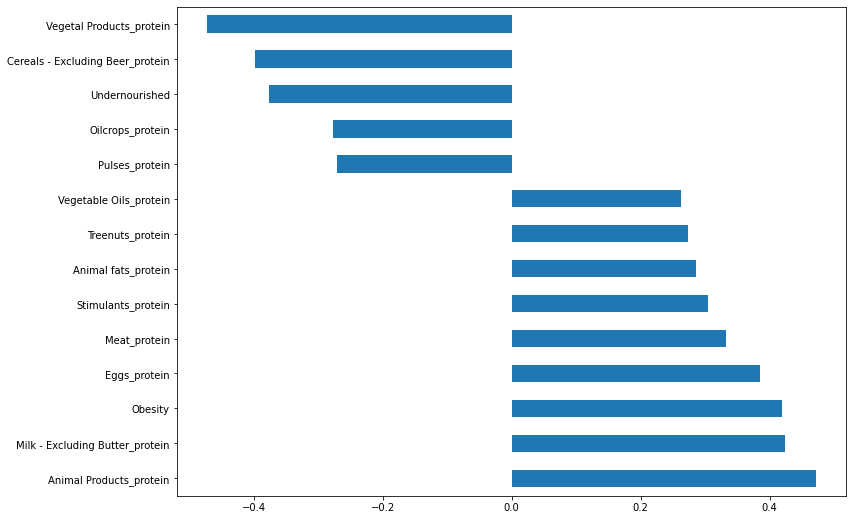

In [58]:
plt.figure(figsize=(12, 9))
golden_features_dict['Confirmed'].plot(kind='barh')

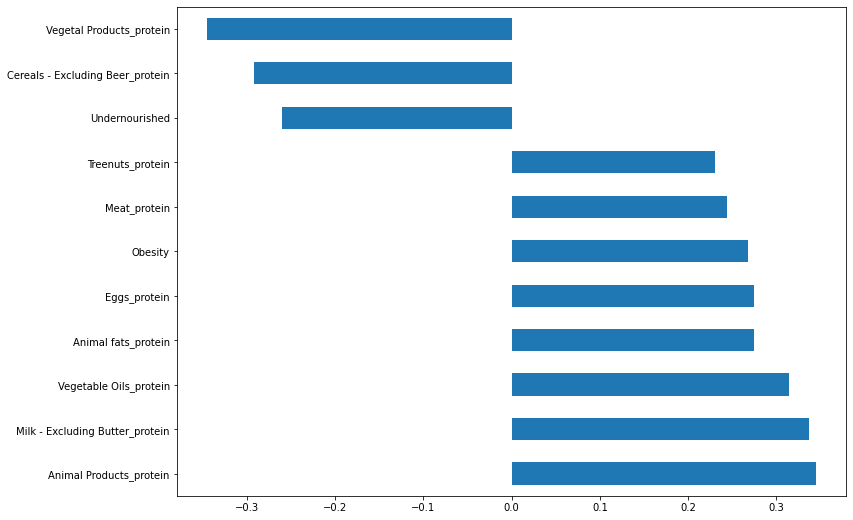

In [59]:
plt.figure(figsize=(12, 9))
golden_features_dict['Deaths'].plot(kind='barh')

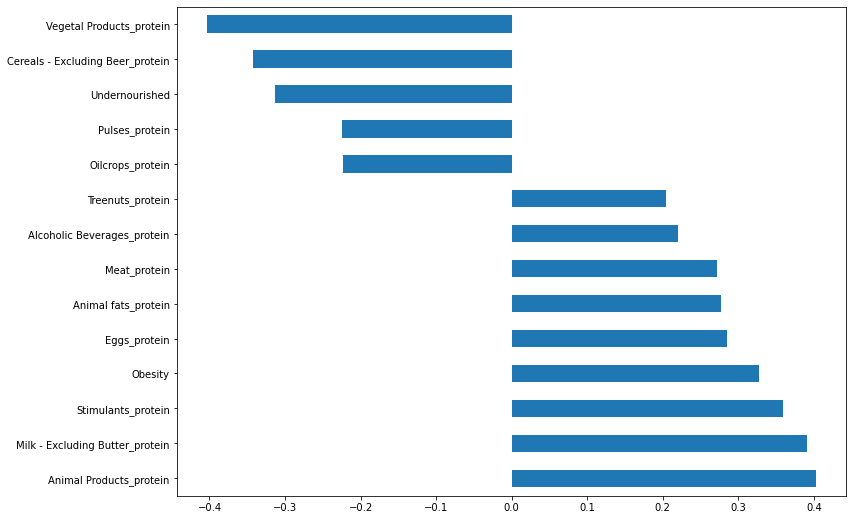

In [60]:
plt.figure(figsize=(12, 9))
golden_features_dict['Recovered'].plot(kind='barh')

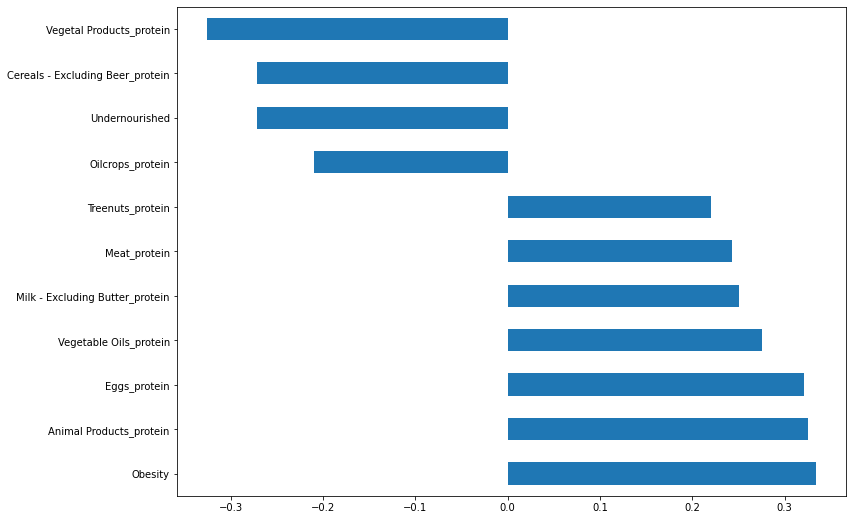

In [61]:
plt.figure(figsize=(12, 9))
golden_features_dict['Active'].plot(kind='barh')

## Remover outliers

In [62]:
colunas_outlier = data_num.columns.to_list()

dataset['is outlier'] = detectar_outliers(dataset, colunas=colunas_outlier, metodo='local outlier fraction', 
                                          contamination=0.000001)
print (str(list(dataset['is outlier']).count(1)) + ' outliers detectados')
dataset = dataset[dataset['is outlier']==0]

1 outliers detectados


## Separando features das targets

In [63]:
y_dict = {}
for t in targets:
    y_dict[t] = dataset[t]

## Feature engineering

In [64]:
cols = dataset.columns.to_list()

In [65]:
features = [f for f in cols if f not in targets]

x_features = dataset[features].copy()

In [66]:
x_features.head()

,Country,Obesity,Undernourished,Population,Unit (all except Population),Alcoholic Beverages_protein,Animal Products_protein,Animal fats_protein,"Aquatic Products, Other_protein",Cereals - Excluding Beer_protein,...,Spices_protein,Starchy Roots_protein,Stimulants_protein,Sugar Crops_protein,Sugar & Sweeteners_protein,Treenuts_protein,Vegetal Products_protein,Vegetable Oils_protein,Vegetables_protein,is outlier
0,Afghanistan,4.5,29.800000,38042000.0,%,0.0000,9.7523,0.0277,0.0,35.9771,...,0.1664,0.1941,0.5546,0.0,0.0000,0.1387,40.2477,0.0000,1.1370,0
1,Albania,22.3,6.200000,2858000.0,%,0.1840,27.7469,0.0711,0.0,14.2331,...,0.0000,0.8867,0.2635,0.0,0.0042,0.2677,22.2552,0.0084,3.2456,0
2,Algeria,26.6,3.900000,43406000.0,%,0.0323,13.8360,0.0054,0.0,26.5633,...,0.1776,1.4638,0.4628,0.0,0.0000,0.2745,36.1694,0.0269,3.1267,0
3,Angola,6.8,25.000000,31427000.0,%,0.6285,15.2311,0.0277,0.0,20.3882,...,0.0000,5.1941,0.1017,0.0,0.0092,0.0092,34.7782,0.0092,0.8133,0
4,Antigua and Barbuda,19.1,11.258442,97000.0,%,0.1535,33.1901,0.1289,0.0,10.5108,...,0.3438,0.4666,0.4113,0.0,0.0000,0.0737,16.8161,0.0430,1.6024,0


In [67]:
del x_features['Unit (all except Population)']

In [68]:
del x_features['is outlier']

In [69]:
x_features.dtypes.value_counts()

float64    26
object      1
dtype: int64

In [70]:
x_features_orig = x_features.copy()

In [71]:
data_num = x_features.select_dtypes(include = ['float64', 'int64'])
data_cat = x_features.select_dtypes(include = ['object'])
colunas_a_normalizar = data_num.columns.tolist()
colunas_a_codificar = data_cat.columns.tolist()

<Figure size 432x288 with 0 Axes>

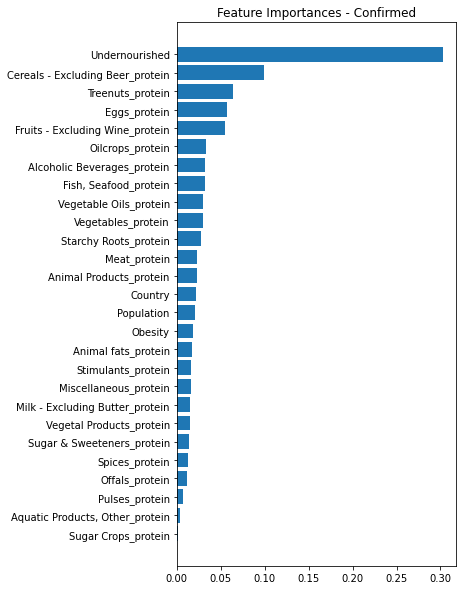

<Figure size 432x288 with 0 Axes>

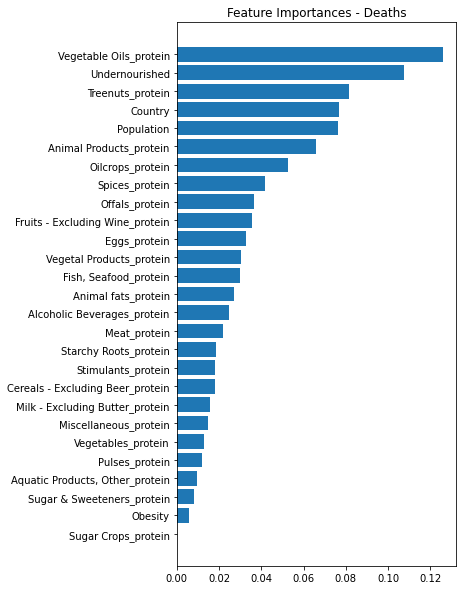

<Figure size 432x288 with 0 Axes>

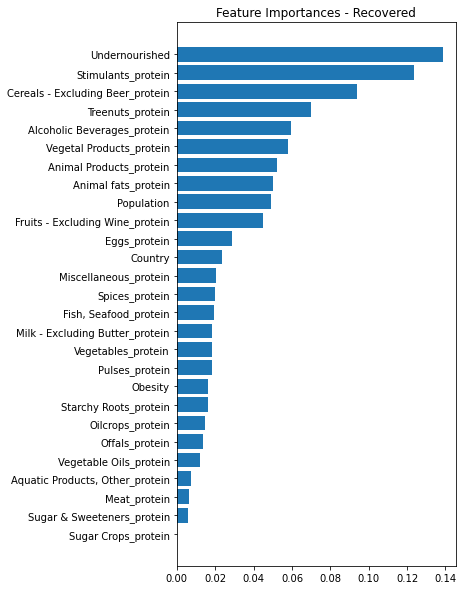

<Figure size 432x288 with 0 Axes>

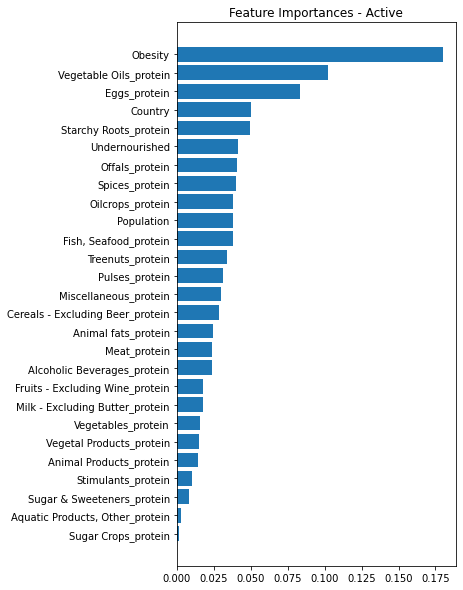

In [72]:
features_importances_dict = {}
features_names_dict = {}
for t in targets:
    features_names_sort, feature_importances_sort = importancia_das_features(x_features, y_dict[t], colunas_numericas=colunas_a_normalizar, colunas_categoricas=colunas_a_codificar, nome_variavel = t)
    features_importances_dict[t] = feature_importances_sort
    features_names_dict[t] = features_names_sort

<Figure size 432x288 with 0 Axes>

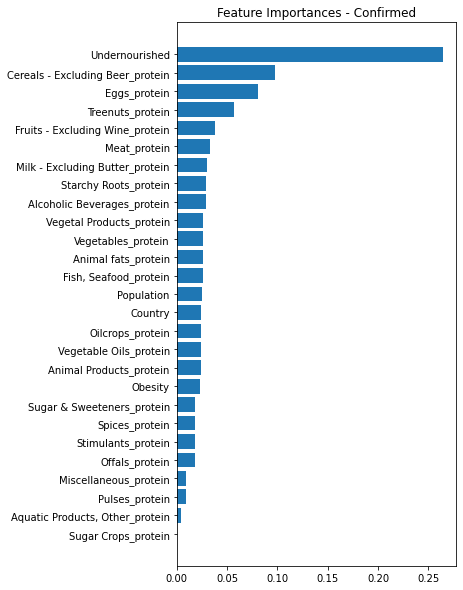

Undernourished 0.2641974594794367
Cereals - Excluding Beer_protein 0.09736917115453231
Eggs_protein 0.08085966370336299
Treenuts_protein 0.0571561738375006
Fruits - Excluding Wine_protein 0.0375146517015166
Meat_protein 0.03347009240416224
Milk - Excluding Butter_protein 0.02978730897698589
Starchy Roots_protein 0.02903875144134984
Alcoholic Beverages_protein 0.028663535932410687
Vegetal Products_protein 0.02629099603294046
Vegetables_protein 0.025810569686966107
Animal fats_protein 0.02576019649214473
Fish, Seafood_protein 0.02575570644068804
Population 0.02499382700685181
Country 0.024495337458696424
Oilcrops_protein 0.02415365206859323
Vegetable Oils_protein 0.0237917736424533
Animal Products_protein 0.023705451858700554
Obesity 0.02267230468251047
Sugar & Sweeteners_protein 0.018174905624734675
Spices_protein 0.018170549281034575
Stimulants_protein 0.018001042373002586
Offals_protein 0.01765147103926136
Miscellaneous_protein 0.009438024800889889
Pulses_protein 0.009359885444257435


<Figure size 432x288 with 0 Axes>

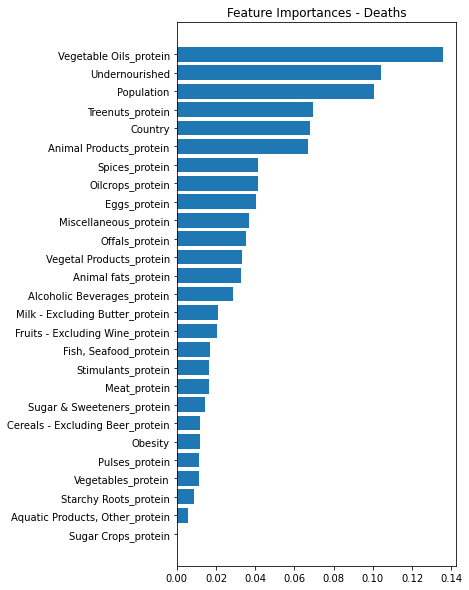

Vegetable Oils_protein 0.13553947432342955
Undernourished 0.10396499450438501
Population 0.10048914960965093
Treenuts_protein 0.06952657411324663
Country 0.06779630928701508
Animal Products_protein 0.06676425272213493
Spices_protein 0.04154260765912639
Oilcrops_protein 0.04140121962435668
Eggs_protein 0.040637486871178644
Miscellaneous_protein 0.03656646684279383
Offals_protein 0.035060163605302834
Vegetal Products_protein 0.03316038756333227
Animal fats_protein 0.032743370338453405
Alcoholic Beverages_protein 0.02842062563585952
Milk - Excluding Butter_protein 0.021150834588893875
Fruits - Excluding Wine_protein 0.020513636545441485
Fish, Seafood_protein 0.01702445140321148
Stimulants_protein 0.016278151166054477
Meat_protein 0.016162811729155693
Sugar & Sweeteners_protein 0.014522120257365167
Cereals - Excluding Beer_protein 0.012072005753730122
Obesity 0.01167760244204199
Pulses_protein 0.011419929799482996
Vegetables_protein 0.011195165486660668
Starchy Roots_protein 0.008744808749

<Figure size 432x288 with 0 Axes>

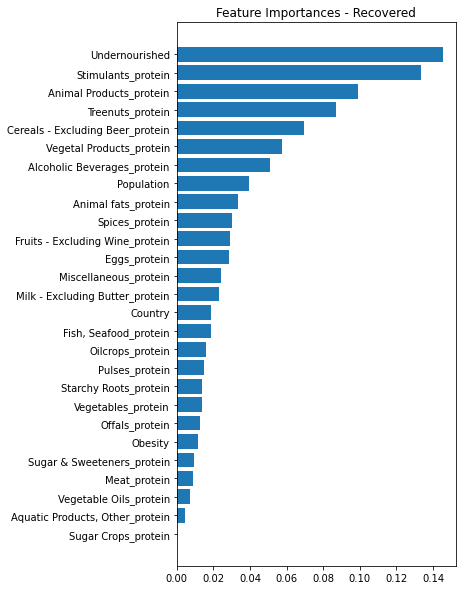

Undernourished 0.14519230914490705
Stimulants_protein 0.13335881899217017
Animal Products_protein 0.0990510181881383
Treenuts_protein 0.08708603011707909
Cereals - Excluding Beer_protein 0.06937380445841496
Vegetal Products_protein 0.05764036331622344
Alcoholic Beverages_protein 0.05077635712072872
Population 0.03938616325932097
Animal fats_protein 0.03359924391324811
Spices_protein 0.03023732958178045
Fruits - Excluding Wine_protein 0.028920140394350705
Eggs_protein 0.028434712606498744
Miscellaneous_protein 0.02418526882678466
Milk - Excluding Butter_protein 0.022928861403487613
Country 0.018891455942607605
Fish, Seafood_protein 0.018501011094593022
Oilcrops_protein 0.016168724506839566
Pulses_protein 0.014980196231149408
Starchy Roots_protein 0.013832373100214063
Vegetables_protein 0.013597677983671848
Offals_protein 0.012458910749478013
Obesity 0.011474782459117473
Sugar & Sweeteners_protein 0.009503744212812243
Meat_protein 0.008996707199642412
Vegetable Oils_protein 0.00702354687

<Figure size 432x288 with 0 Axes>

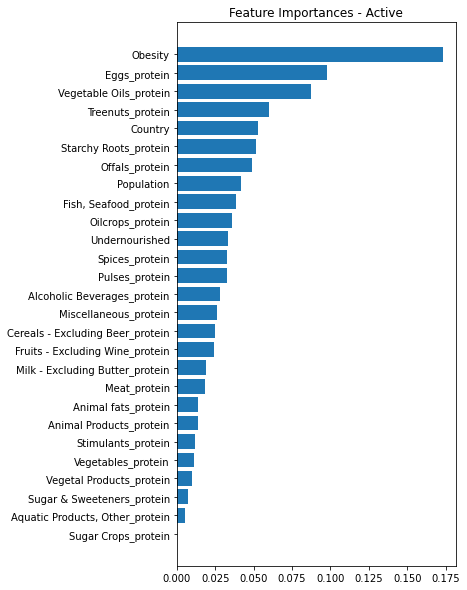

Obesity 0.17304155554429937
Eggs_protein 0.09805079009472649
Vegetable Oils_protein 0.08733803438188265
Treenuts_protein 0.05977703359182966
Country 0.05270620869965553
Starchy Roots_protein 0.051452382716449356
Offals_protein 0.04884545546946768
Population 0.04187897756306001
Fish, Seafood_protein 0.03858393868179368
Oilcrops_protein 0.03613944726699409
Undernourished 0.03301883233486734
Spices_protein 0.032902938883482266
Pulses_protein 0.03288580054032664
Alcoholic Beverages_protein 0.028062976351170534
Miscellaneous_protein 0.026002888180798024
Cereals - Excluding Beer_protein 0.024646658212977273
Fruits - Excluding Wine_protein 0.024141286071262605
Milk - Excluding Butter_protein 0.019302130162432065
Meat_protein 0.018092057497601653
Animal fats_protein 0.014004843065845742
Animal Products_protein 0.013765600507831549
Stimulants_protein 0.012034667183781001
Vegetables_protein 0.010944944265832509
Vegetal Products_protein 0.009581408643350626
Sugar & Sweeteners_protein 0.0073623994

In [73]:
x_features_slct = {}
features_slct = {}
for t in targets:
    x_features_slct[t], features_slct[t] = selecionar_features(x_features, y_dict[t], y_name=t, colunas_numericas=colunas_a_normalizar, colunas_categoricas=colunas_a_codificar, limite_corr=0.9, limite_importancia=0.99, quantidade=99)


In [74]:
for t in targets:
    print (t + " " +str(len(features_slct[t])))

Confirmed 25
Deaths 25
Recovered 25
Active 25


<Figure size 432x288 with 0 Axes>

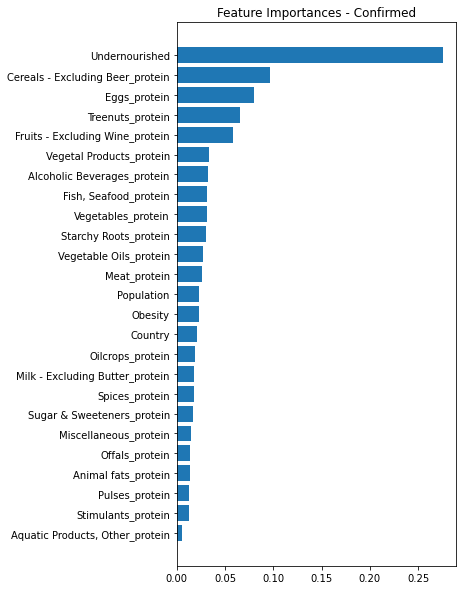

<Figure size 432x288 with 0 Axes>

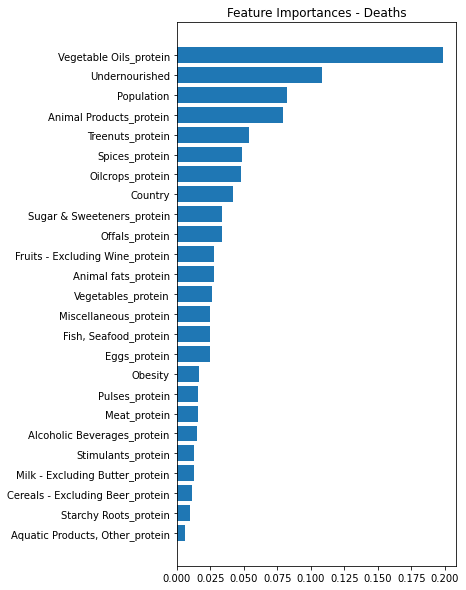

<Figure size 432x288 with 0 Axes>

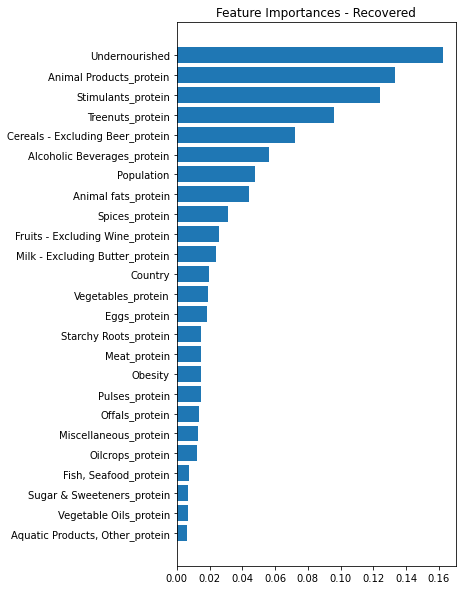

<Figure size 432x288 with 0 Axes>

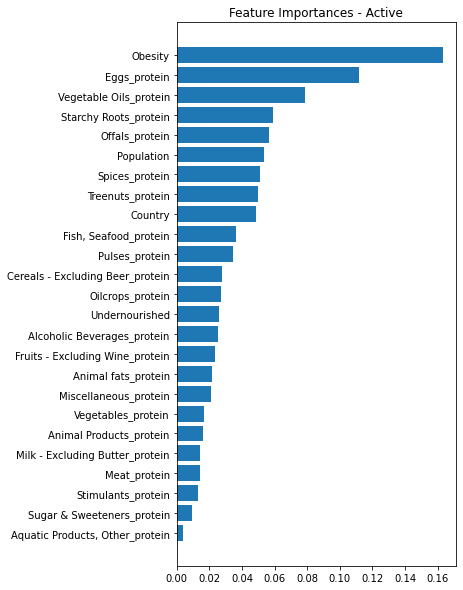

In [75]:
for t in targets:
    data_num = x_features_slct[t].select_dtypes(include = ['float64', 'int64'])
    data_cat = x_features_slct[t].select_dtypes(include = ['object'])
    colunas_num_slct = data_num.columns.tolist()
    colunas_categ_slct = data_cat.columns.tolist()
    
    x_features_importance_pratica = x_features_slct[t][features_slct[t]]
    
    features_names_sort_slct, feature_importances_sort_slct = importancia_das_features(x_features_importance_pratica, y_dict[t], colunas_numericas=colunas_num_slct, colunas_categoricas = colunas_categ_slct, nome_variavel = t)


## Separando dado de treino e teste

In [76]:
x_train_dict = {}
y_train_dict = {}
x_test_dict = {}
y_test_dict = {}

x_train_dict_sens = {}
y_train_dict_sens = {}
x_test_dict_sens = {}
y_test_dict_sens = {}

for t in targets:
    x_train_dict[t], x_test_dict[t], y_train_dict[t], y_test_dict[t] = train_test_split(x_features_slct[t], y_dict[t], test_size=0.01, random_state=42)
    x_train_dict_sens[t], x_test_dict_sens[t], y_train_dict_sens[t], y_test_dict_sens[t] = train_test_split(x_features_slct[t], y_dict[t], test_size=0.5, random_state=42)
    print (y_train_dict[t].shape, y_test_dict[t].shape)

(158,) (2,)
(158,) (2,)
(158,) (2,)
(158,) (2,)


## Pré processamento

In [77]:
colunas_a_normalizar = {}
colunas_a_codificar = {}
for t in targets:
    data_num = x_features_slct[t].select_dtypes(include = ['float64', 'int64'])
    data_cat = x_features_slct[t].select_dtypes(include = ['object'])
    colunas_a_normalizar[t] = data_num.columns.tolist()
    colunas_a_codificar[t] = data_cat.columns.tolist()

scaler_dict = {}
for t in targets:
    _, scaler = normalizar_numericas(x_train_dict[t], colunas_a_normalizar[t])
    _, scaler_sens = normalizar_numericas(x_train_dict_sens[t], colunas_a_normalizar[t])
    scaler_dict[t] = scaler
    x_test_dict[t][colunas_a_normalizar[t]] = scaler_dict[t].transform(x_test_dict[t][colunas_a_normalizar[t]])
    x_test_dict_sens[t][colunas_a_normalizar[t]] = scaler_sens.transform(x_test_dict_sens[t][colunas_a_normalizar[t]])

encoder_dict = {}
for t in targets:
    if colunas_a_codificar[t] == []: continue
    x_train_dict[t], enc = codificar_categoricas(x_train_dict[t], colunas_categoricas = colunas_a_codificar[t])
    x_train_dict_sens[t], enc_sens = codificar_categoricas(x_train_dict_sens[t], colunas_categoricas = colunas_a_codificar[t])
    encoder_dict[t] = enc
    test_categ = pd.DataFrame(enc.transform(x_test_dict[t][colunas_a_codificar[t]]).toarray())
    x_test_dict[t].reset_index(inplace=True, drop=True)
    x_test_dict[t] = pd.concat([test_categ, x_test_dict[t][colunas_a_normalizar[t]]], axis=1)
    
    test_categ_sens = pd.DataFrame(enc_sens.transform(x_test_dict_sens[t][colunas_a_codificar[t]]).toarray())
    x_test_dict_sens[t].reset_index(inplace=True, drop=True)
    x_test_dict_sens[t] = pd.concat([test_categ_sens, x_test_dict_sens[t][colunas_a_normalizar[t]]], axis=1)

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


## Análise de sensibilidade

In [78]:
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
msle_scorer = make_scorer(mean_squared_log_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score, greater_is_better=True)

metricas = {'mse': mse_scorer,
            'mae': mae_scorer
           }

errors = [mean_squared_error, mean_absolute_error]

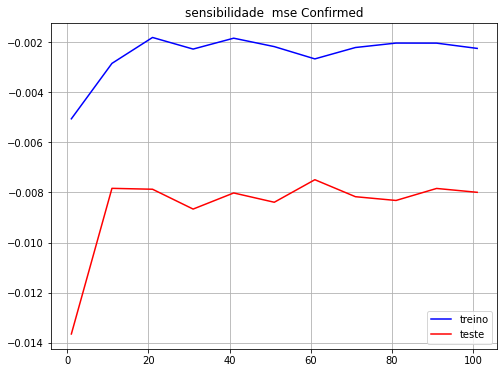

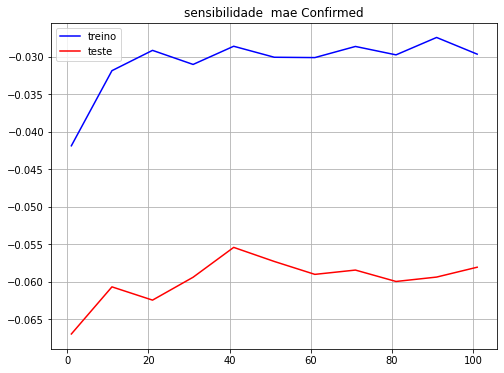

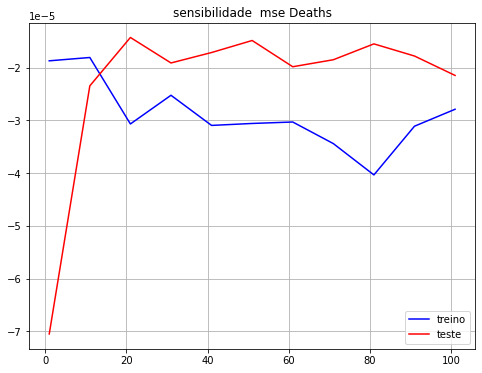

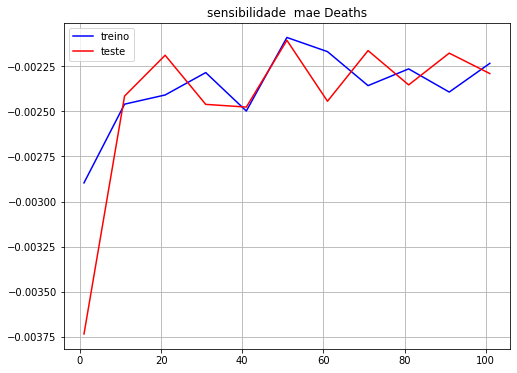

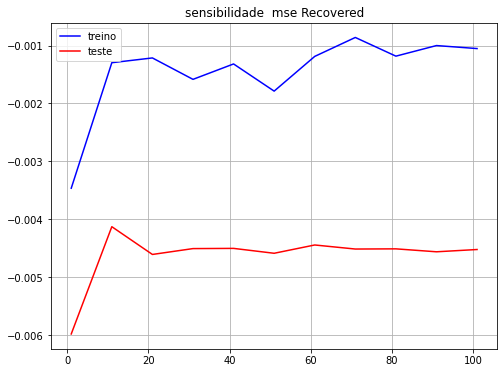

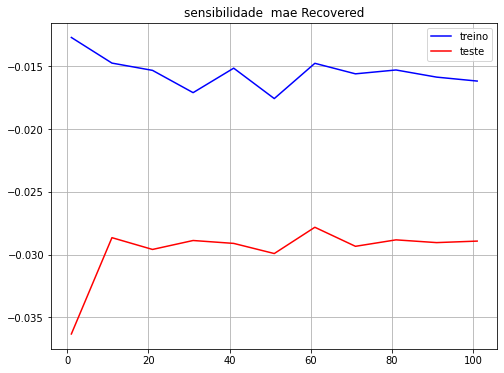

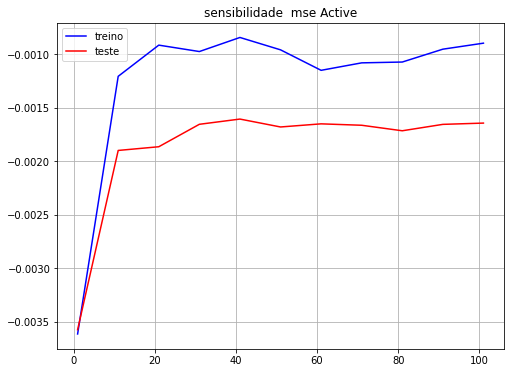

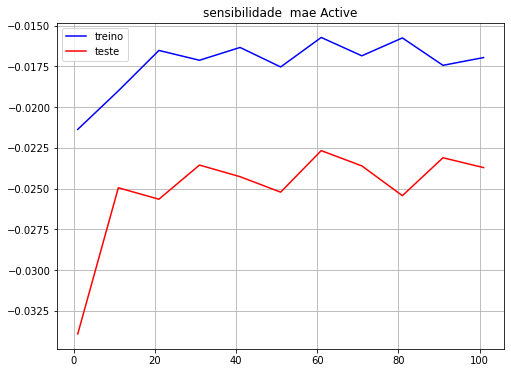

In [79]:
lista_n_arvores = [i for i in range(1, 111, 10)]

for t in targets:
    for met_nome, metrica in metricas.items():
        train_results = []
        test_results = []
        for n_arvores in lista_n_arvores:
            model = BaggingRegressor(base_estimator=ExtraTreeRegressor(), 
                                     n_estimators=n_arvores,
                                     n_jobs = -1)

            model.fit(x_train_dict_sens[t], y_train_dict_sens[t])
            train_pred = model.predict(x_train_dict_sens[t])
            test_pred = model.predict(x_test_dict_sens[t])
            train_r2 = metrica(model, x_train_dict_sens[t], y_train_dict_sens[t])
            test_r2 = metrica(model, x_test_dict_sens[t], y_test_dict_sens[t])
            train_results.append(train_r2)
            test_results.append(test_r2)

        plt.figure(figsize=(8,6))
        plt.plot(lista_n_arvores, train_results, 'b', label="treino")
        plt.plot(lista_n_arvores, test_results, 'r', label="teste")
        plt.title('sensibilidade ' + ' ' + met_nome + ' ' + t)
        plt.legend()
        plt.grid()

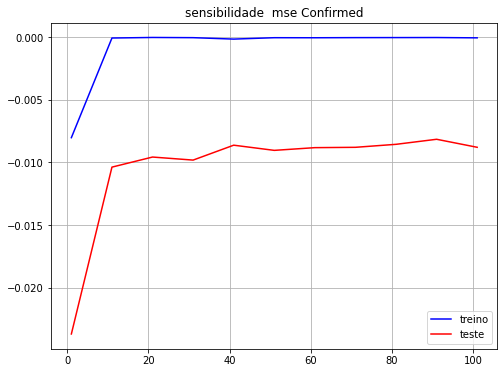

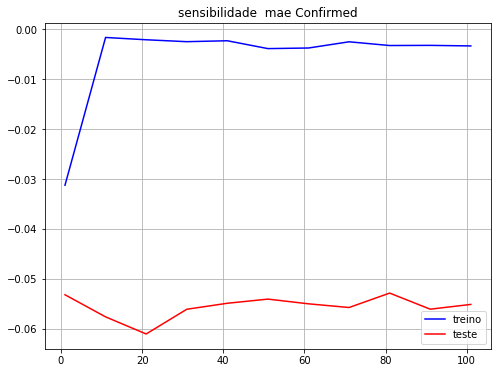

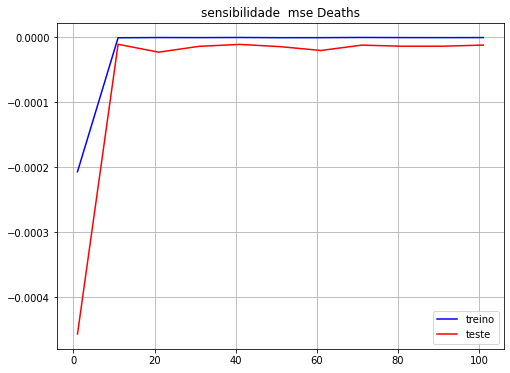

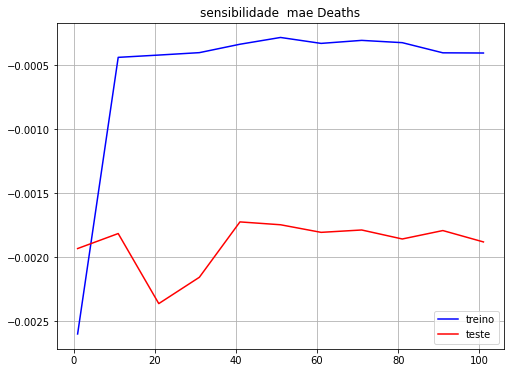

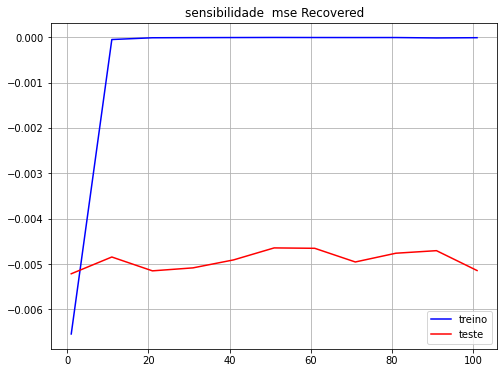

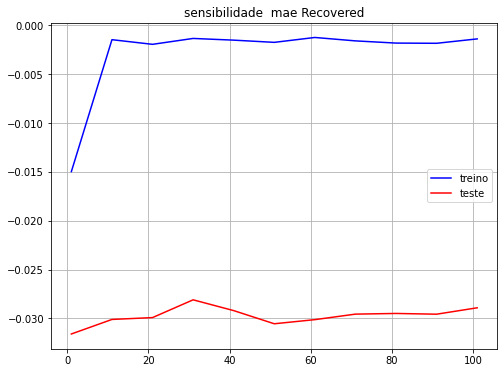

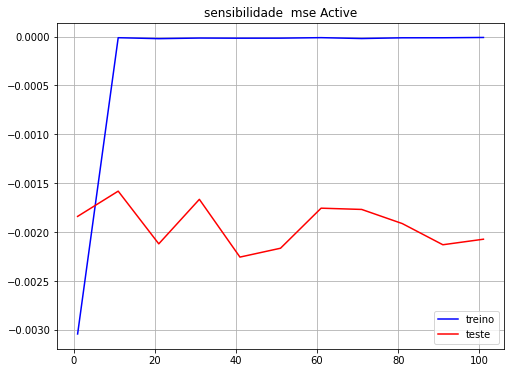

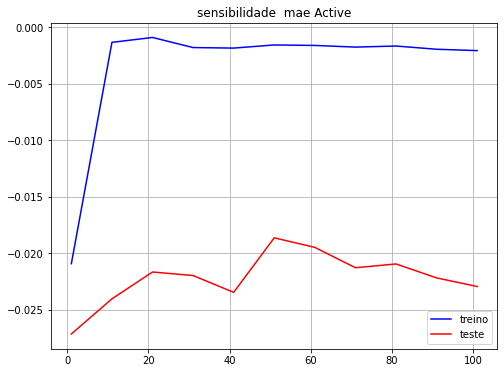

In [80]:
lista_n_arvores = [i for i in range(1, 111, 10)]

for t in targets:
    for met_nome, metrica in metricas.items():
        train_results = []
        test_results = []
        for n_arvores in lista_n_arvores:
            model = AdaBoostRegressor(base_estimator=ExtraTreeRegressor(), 
                                      n_estimators=n_arvores)

            model.fit(x_train_dict_sens[t], y_train_dict_sens[t])
            train_pred = model.predict(x_train_dict_sens[t])
            test_pred = model.predict(x_test_dict_sens[t])
            train_r2 = metrica(model, x_train_dict_sens[t], y_train_dict_sens[t])
            test_r2 = metrica(model, x_test_dict_sens[t], y_test_dict_sens[t])
            train_results.append(train_r2)
            test_results.append(test_r2)

        plt.figure(figsize=(8,6))
        plt.plot(lista_n_arvores, train_results, 'b', label="treino")
        plt.plot(lista_n_arvores, test_results, 'r', label="teste")
        plt.title('sensibilidade ' + ' ' + met_nome + ' ' + t)
        plt.legend()
        plt.grid()

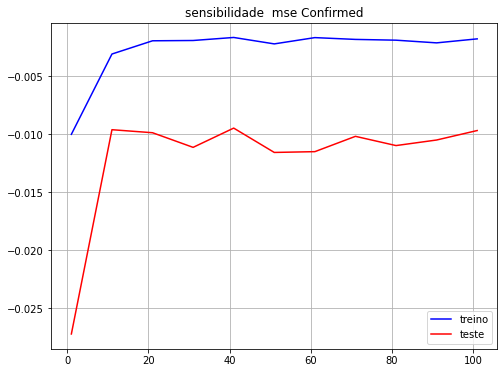

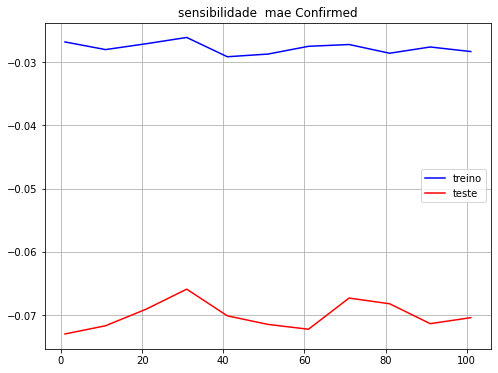

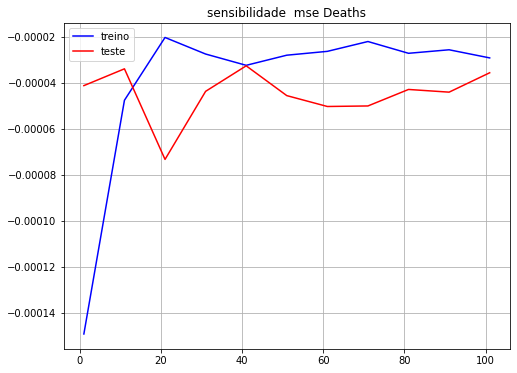

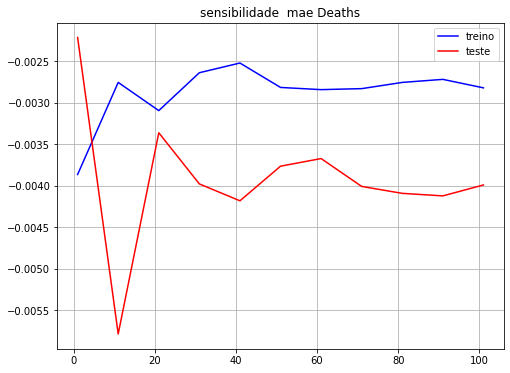

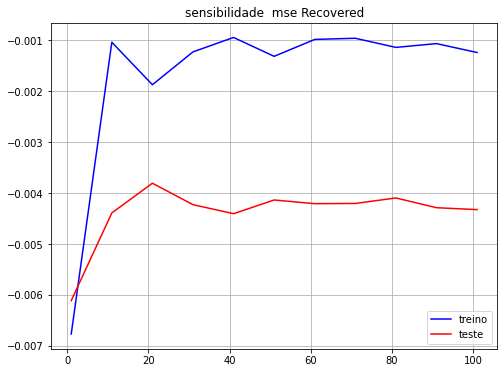

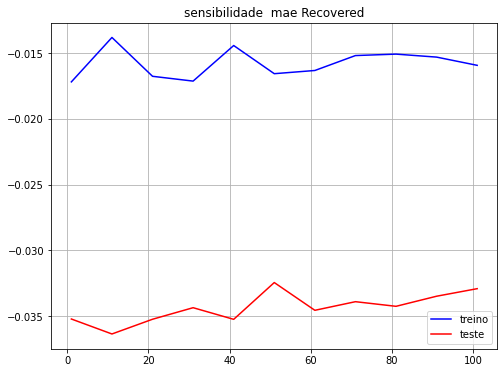

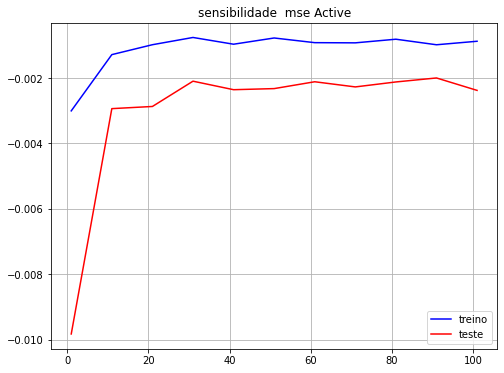

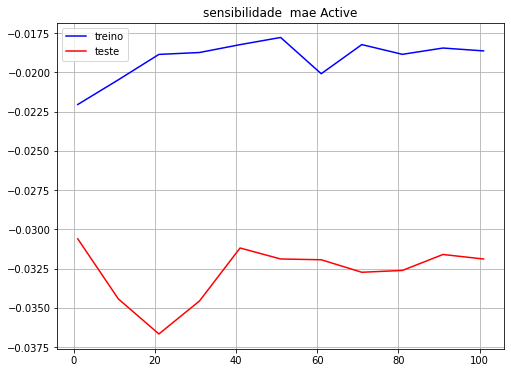

In [81]:
lista_n_arvores = [i for i in range(1, 111, 10)]

for t in targets:
    for met_nome, metrica in metricas.items():
        train_results = []
        test_results = []
        for n_arvores in lista_n_arvores:
            model = RandomForestRegressor(n_estimators=n_arvores,
                                     n_jobs = -1)

            model.fit(x_train_dict_sens[t], y_train_dict_sens[t])
            train_pred = model.predict(x_train_dict_sens[t])
            test_pred = model.predict(x_test_dict_sens[t])
            train_r2 = metrica(model, x_train_dict_sens[t], y_train_dict_sens[t])
            test_r2 = metrica(model, x_test_dict_sens[t], y_test_dict_sens[t])
            train_results.append(train_r2)
            test_results.append(test_r2)

        plt.figure(figsize=(8,6))
        plt.plot(lista_n_arvores, train_results, 'b', label="treino")
        plt.plot(lista_n_arvores, test_results, 'r', label="teste")
        plt.title('sensibilidade ' + ' ' + met_nome + ' ' + t)
        plt.legend()
        plt.grid()

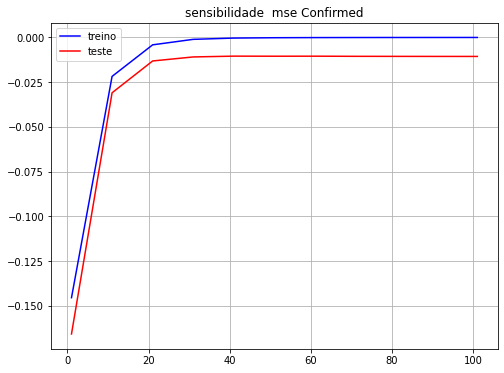

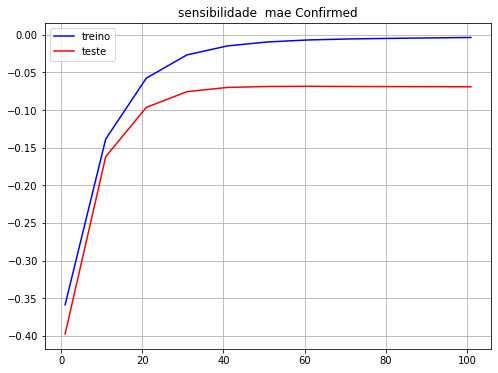

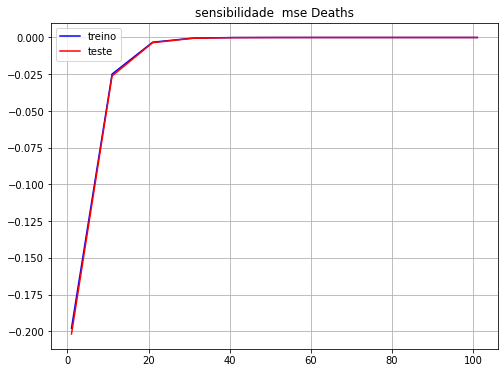

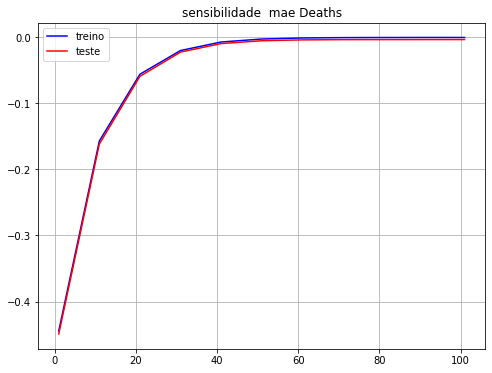

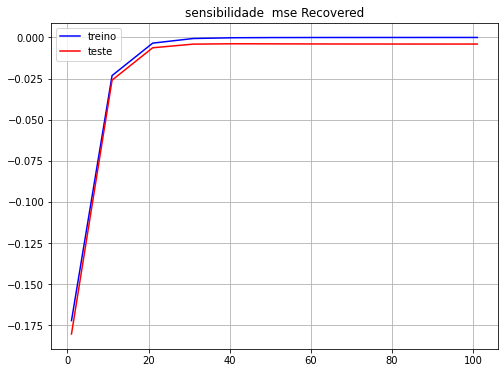

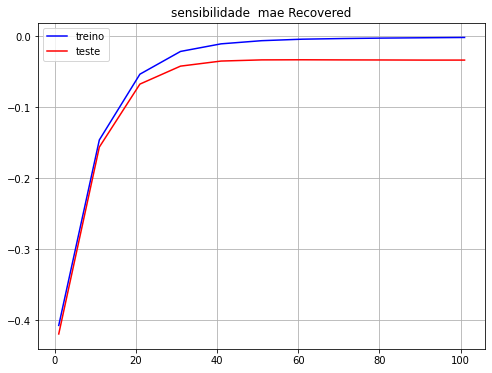

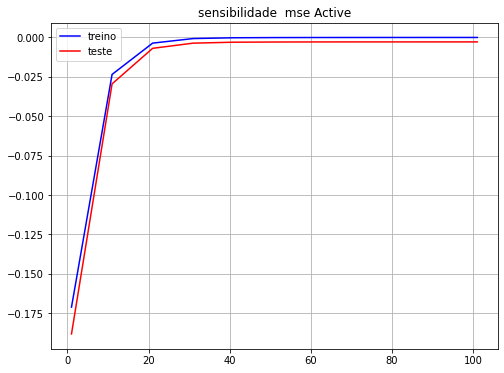

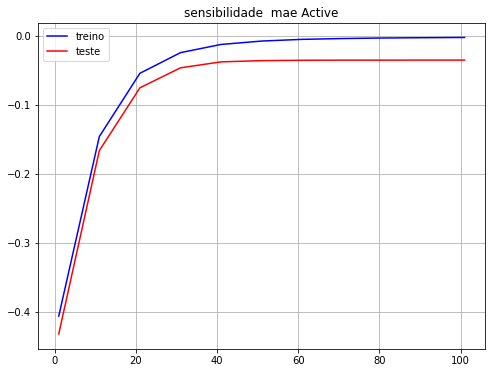

In [82]:
lista_n_arvores = [i for i in range(1, 111, 10)]

for t in targets:
    for met_nome, metrica in metricas.items():
        train_results = []
        test_results = []
        for n_arvores in lista_n_arvores:
            model = xgb.XGBRegressor(n_estimators=n_arvores,
                                     n_jobs = -1, objective='reg:squarederror')

            model.fit(x_train_dict_sens[t], y_train_dict_sens[t])
            train_pred = model.predict(x_train_dict_sens[t])
            test_pred = model.predict(x_test_dict_sens[t])
            train_r2 = metrica(model, x_train_dict_sens[t], y_train_dict_sens[t])
            test_r2 = metrica(model, x_test_dict_sens[t], y_test_dict_sens[t])
            train_results.append(train_r2)
            test_results.append(test_r2)

        plt.figure(figsize=(8,6))
        plt.plot(lista_n_arvores, train_results, 'b', label="treino")
        plt.plot(lista_n_arvores, test_results, 'r', label="teste")
        plt.title('sensibilidade ' + ' ' + met_nome + ' ' + t)
        plt.legend()
        plt.grid()

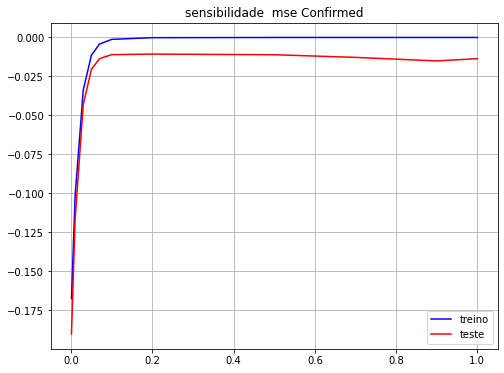

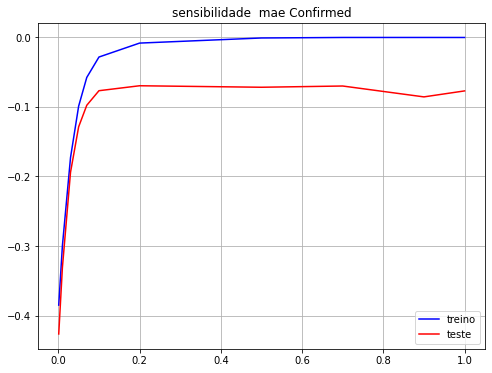

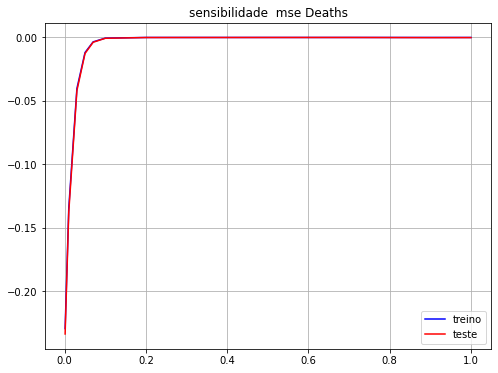

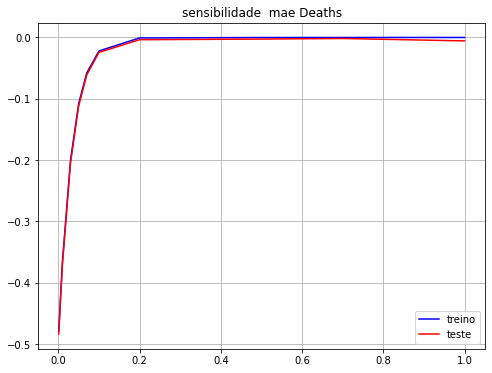

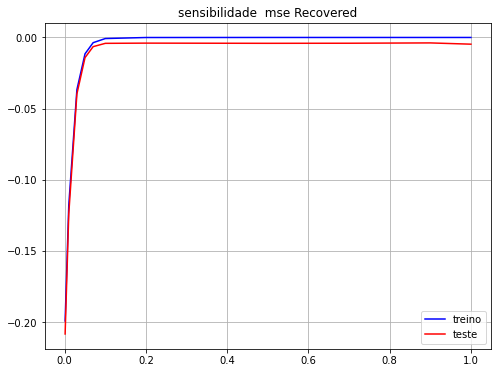

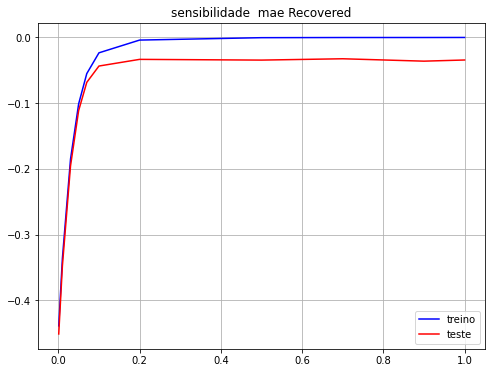

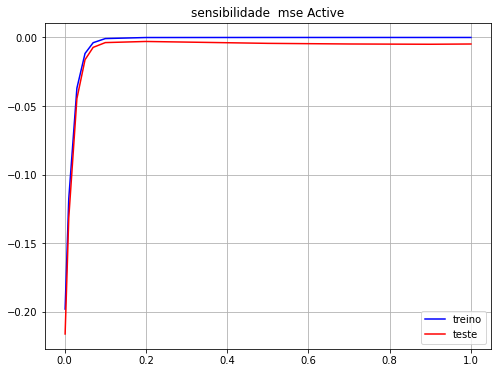

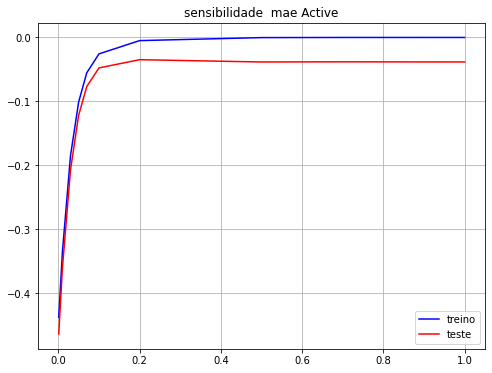

In [97]:
lista_learning_rate = [0.001, 0.01, 0.03, 0.05, 0.07, 0.1, 0.2, 0.5, 0.7, 0.9, 1.]

for t in targets:
    for met_nome, metrica in metricas.items():
        train_results = []
        test_results = []
        for lr in lista_learning_rate:
            model = xgb.XGBRegressor(n_estimators=30,
                                     learning_rate=lr,
                                     n_jobs = -1, objective='reg:squarederror')

            model.fit(x_train_dict_sens[t], y_train_dict_sens[t])
            train_pred = model.predict(x_train_dict_sens[t])
            test_pred = model.predict(x_test_dict_sens[t])
            train_r2 = metrica(model, x_train_dict_sens[t], y_train_dict_sens[t])
            test_r2 = metrica(model, x_test_dict_sens[t], y_test_dict_sens[t])
            train_results.append(train_r2)
            test_results.append(test_r2)

        plt.figure(figsize=(8,6))
        plt.plot(lista_learning_rate, train_results, 'b', label="treino")
        plt.plot(lista_learning_rate, test_results, 'r', label="teste")
        plt.title('sensibilidade ' + ' ' + met_nome + ' ' + t)
        plt.legend()
        plt.grid()

## Model selection: otimização

In [83]:
modelos_dict = {'ridge': Ridge(),
                'lasso': Lasso(),
                'bagging': BaggingRegressor(),
                'adaboost': AdaBoostRegressor(),
                'random forest': RandomForestRegressor(),
                'gradient boosting':xgb.XGBRegressor(),
                }

ridge_param_grid = {'alpha': stats.uniform(loc=0.001, scale=1000),
                    'max_iter': np.arange(1000, 10000, 1000),
                    }

lasso_param_grid = {'alpha': stats.uniform(loc=0.001, scale=1000),
                    'max_iter': np.arange(1000, 10000, 1000),
                    }

bagging_param_grid = {'base_estimator': [DecisionTreeRegressor(), ExtraTreeRegressor(), Ridge(), Lasso()], 
                      'n_estimators': [10, 20, 30, 40, 50], 
                      'max_samples': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 
                      'max_features': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 
                      'bootstrap': [True], 
                      'bootstrap_features': [False, True],
                      'n_jobs': [-1]
                     }

adaboost_param_grid = {'base_estimator': [DecisionTreeRegressor(), ExtraTreeRegressor(), Ridge(), Lasso()],
                       'n_estimators': [10, 20, 30, 40, 50], 
                       'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 
                       'loss': ['linear', 'square', 'exponential']
                      }

rf_param_grid = {'n_estimators': [10, 20, 30, 40, 50],
                 'max_features': np.arange(1, 20, 1),
                 'max_depth':np.arange(1, 20, 1),
                 'min_samples_split': np.arange(2, 20, 1),
                 "bootstrap": [True, False],
                 'n_jobs': [-1]
                 }

gdbt_param_grid = {'max_depth': np.arange(3, 20, 1),
                   'learning_rate': stats.uniform(loc=0.1, scale=0.3),
                   'n_estimators': [10, 20, 30, 40, 50],
                   'n_jobs': [-1],
                   'gamma': stats.uniform(loc=0.001, scale=10),
                   'subsample': stats.uniform(loc=0.1, scale=0.9),
                   'colsample_bytree': stats.uniform(loc=0.1, scale=0.9),
                   'reg_alpha': stats.uniform(loc=0.001, scale=10),
                   'reg_lambda': stats.uniform(loc=0.01, scale=5),
                   'booster': ['gbtree', 'gblinear', 'dart'],
                   'objective': ['reg:squarederror']
                   }


param_dict = {'ridge':ridge_param_grid,
              'lasso': lasso_param_grid,
              'bagging': bagging_param_grid,
              'adaboost': adaboost_param_grid,
              'random forest': rf_param_grid,
              'gradient boosting':gdbt_param_grid,
             }

In [84]:
n_iteracoes = 10

In [85]:
%%time

resultados_dict = {}
otm_time_dict = {}
melhor_modelo_dict = {}
melhor_modelo_nome = {}
melhores_parametros_dict = {}
best_score = {}
resultados = {}

n_folds = 10

loo = LeaveOneOut()

for t in targets:
    _, _, _, resultados[t], _ = busca_aleatoria(x_train_dict[t], y_train_dict[t], Ridge(), param_dict['ridge'], metricas, n_folds=loo.split(x_train_dict[t]), n_iter=n_iteracoes)
    resultados[t]['nome'] = 'ridge'

for t in targets:
    best_score[t] = -9999.
    melhor_modelo_nome[t] = None
    melhor_modelo_dict[t] = None
    melhores_parametros_dict[t] = None
    for nome, modelo in modelos_dict.items():
        print (nome)
        melhor_modelo, melhores_parametros, score, result, otm_time = busca_aleatoria(x_train_dict[t], y_train_dict[t], modelo, param_dict[nome], metricas, n_folds=loo.split(x_train_dict[t]), n_iter=n_iteracoes)
        result['nome'] = nome
        resultados[t] = pd.concat([resultados[t], result])
        if score > best_score[t]:
            melhor_modelo_nome[t] = nome
            melhor_modelo_dict[t] = melhor_modelo
            melhores_parametros_dict[t] = melhores_parametros
            best_score[t] = score



 
 buscando melhores parâmetros...
melhores parâmetros encontrados

 
 buscando melhores parâmetros...
melhores parâmetros encontrados

 
 buscando melhores parâmetros...
melhores parâmetros encontrados

 
 buscando melhores parâmetros...
melhores parâmetros encontrados
ridge

 
 buscando melhores parâmetros...
melhores parâmetros encontrados
lasso

 
 buscando melhores parâmetros...
melhores parâmetros encontrados
bagging

 
 buscando melhores parâmetros...
melhores parâmetros encontrados
adaboost

 
 buscando melhores parâmetros...
melhores parâmetros encontrados
random forest

 
 buscando melhores parâmetros...
melhores parâmetros encontrados
gradient boosting

 
 buscando melhores parâmetros...
melhores parâmetros encontrados
ridge

 
 buscando melhores parâmetros...
melhores parâmetros encontrados
lasso

 
 buscando melhores parâmetros...
melhores parâmetros encontrados
bagging

 
 buscando melhores parâmetros...
melhores parâmetros encontrados
adaboost

 
 buscando melhores parâ

In [86]:
for t in targets:
    print (resultados[t].shape)
    resultados[t].sort_values(by='mean_test_'+list(metricas.keys())[0], inplace=True, ascending=False)

(70, 348)
(70, 348)
(70, 348)
(70, 348)


In [87]:
for t in targets:
    for i, (met_nome, metrica) in enumerate(metricas.items()):
        print (met_nome, t, resultados[t]['mean_test_'+list(metricas.keys())[i]].max())

mse Confirmed -0.011162180525520307
mae Confirmed -0.06311518451961162
mse Deaths -9.824749552767053e-05
mae Deaths -0.0038983693429613365
mse Recovered -0.005805519103045832
mae Recovered -0.035960091490239494
mse Active -0.0036590739374014834
mae Active -0.03304980486246929


In [88]:
for t in targets:
    print (t, best_score[t])

Confirmed -0.011162180525520307
Deaths -9.824749552767053e-05
Recovered -0.005805519103045832
Active -0.0036590739374014834


In [89]:
resultados['Confirmed'][['mean_test_mse', 'std_test_mse', 'rank_test_mse', 
                         'mean_test_mae', 'std_test_mae', 'rank_test_mae',
                         'nome']].head(20)

,mean_test_mse,std_test_mse,rank_test_mse,mean_test_mae,std_test_mae,rank_test_mae,nome
6,-0.011162,0.026064,1,-0.072888,0.076482,3,random forest
2,-0.011283,0.027255,2,-0.072357,0.077765,1,random forest
0,-0.011386,0.026522,3,-0.073335,0.077514,5,random forest
4,-0.011391,0.028271,4,-0.073263,0.077612,4,random forest
6,-0.011579,0.026453,1,-0.069717,0.081965,2,bagging
1,-0.011844,0.027960,5,-0.072368,0.081282,2,random forest
3,-0.011946,0.028542,6,-0.075261,0.079259,6,random forest
5,-0.011987,0.030107,7,-0.075936,0.078869,7,random forest
9,-0.012018,0.031125,2,-0.070323,0.084099,4,bagging
0,-0.012128,0.026516,1,-0.063868,0.089714,3,adaboost


In [90]:
resultados['Deaths'][['mean_test_mse', 'std_test_mse', 'rank_test_mse', 
                         'mean_test_mae', 'std_test_mae', 'rank_test_mae',
                         'nome']].head(20)

,mean_test_mse,std_test_mse,rank_test_mse,mean_test_mae,std_test_mae,rank_test_mae,nome
3,-0.000098,0.000468,1,-0.004501,0.008831,1,random forest
8,-0.000108,0.000491,2,-0.004809,0.009195,3,random forest
5,-0.000109,0.000510,3,-0.004871,0.009240,5,random forest
8,-0.000111,0.000521,1,-0.004668,0.009442,3,bagging
4,-0.000113,0.000518,4,-0.005076,0.009319,8,random forest
7,-0.000113,0.000504,5,-0.005050,0.009344,7,random forest
6,-0.000114,0.000518,6,-0.004799,0.009520,2,random forest
9,-0.000114,0.000509,7,-0.004827,0.009510,4,random forest
3,-0.000115,0.000585,2,-0.004080,0.009937,2,bagging
0,-0.000116,0.000533,8,-0.005049,0.009522,6,random forest


In [91]:
resultados['Recovered'][['mean_test_mse', 'std_test_mse', 'rank_test_mse', 
                         'mean_test_mae', 'std_test_mae', 'rank_test_mae',
                         'nome']].head(20)

,mean_test_mse,std_test_mse,rank_test_mse,mean_test_mae,std_test_mae,rank_test_mae,nome
7,-0.005806,0.025544,1,-0.040549,0.064508,2,random forest
5,-0.005814,0.026454,2,-0.041008,0.064283,3,random forest
4,-0.005891,0.025720,1,-0.043799,0.063030,5,bagging
8,-0.005966,0.026507,3,-0.041529,0.065126,4,random forest
4,-0.006052,0.026560,4,-0.041819,0.065600,5,random forest
9,-0.006076,0.026340,5,-0.042731,0.065195,6,random forest
1,-0.006099,0.026693,6,-0.040404,0.066831,1,random forest
7,-0.006112,0.025987,2,-0.045574,0.063523,6,bagging
8,-0.006172,0.027699,1,-0.043674,0.065307,3,ridge
9,-0.006173,0.027814,1,-0.043533,0.065409,1,ridge


In [92]:
resultados['Active'][['mean_test_mse', 'std_test_mse', 'rank_test_mse', 
                         'mean_test_mae', 'std_test_mae', 'rank_test_mae',
                         'nome']].head(20)

,mean_test_mse,std_test_mse,rank_test_mse,mean_test_mae,std_test_mae,rank_test_mae,nome
5,-0.003659,0.009499,1,-0.038696,0.046494,3,random forest
1,-0.003683,0.010038,2,-0.039187,0.046340,4,random forest
6,-0.003685,0.009912,3,-0.038198,0.047183,1,random forest
9,-0.003691,0.010155,1,-0.038828,0.046723,4,bagging
7,-0.003740,0.010541,4,-0.039440,0.046737,6,random forest
9,-0.003783,0.010469,5,-0.039363,0.047262,5,random forest
7,-0.003788,0.010219,2,-0.037340,0.048931,2,bagging
3,-0.003826,0.010543,6,-0.040726,0.046557,8,random forest
4,-0.003835,0.010495,7,-0.038371,0.048604,2,random forest
8,-0.003860,0.011018,3,-0.037497,0.049537,3,bagging


## Testar modelo

In [93]:
for t in targets:
    modelo = melhor_modelo_dict[t]
    if modelo == None: continue
    modelo.fit(x_train_dict[t], y_train_dict[t])

tabela_compara_dict = {}
train_scores = {}
test_scores = {}
biases = {}
variances = {}

for t in targets:
    modelo = melhor_modelo_dict[t]
    
    tabela_compara_dict[t+' treino'] = []
    tabela_compara_dict[t+' treino baseline'] = []
    
    for i, (met_nome, metrica) in enumerate(metricas.items()):
        if modelo == None: continue
        
        train_scores[t] = metrica(modelo, x_train_dict[t], y_train_dict[t]) 
        test_scores[t] = metrica(modelo, x_test_dict[t], y_test_dict[t])
        
        baseline_train = errors[i](y_train_dict[t], np.ones((y_train_dict[t].shape)) * y_train_dict[t].mean())
        baseline_test = errors[i](y_test_dict[t], np.ones((y_test_dict[t].shape)) * y_train_dict[t].mean())
        
        print ( met_nome + ": score de treino " + str(-metrica(modelo, x_train_dict[t], y_train_dict[t]).round(4)) + " e score de teste: " + str(-metrica(modelo, x_test_dict[t], y_test_dict[t]).round(4)) + " para target: " + str(t))
        print ( met_nome + ": baseline treino " + str(baseline_train.round(4)) + " baseline teste: " + str(baseline_test.round(4)) + " para target: " + str(t))
        
        tabela_compara_dict[t+' treino baseline'].append(baseline_train)
        tabela_compara_dict[t+' treino'].append(-metrica(modelo, x_train_dict[t], y_train_dict[t]))
        

mse: score de treino 0.0032 e score de teste: 0.0008 para target: Confirmed
mse: baseline treino 0.0164 baseline teste: 0.0033 para target: Confirmed
mae: score de treino 0.0381 e score de teste: 0.0284 para target: Confirmed
mae: baseline treino 0.0956 baseline teste: 0.0428 para target: Confirmed
mse: score de treino 0.0 e score de teste: 0.0 para target: Deaths
mse: baseline treino 0.0001 baseline teste: 0.0 para target: Deaths
mae: score de treino 0.0004 e score de teste: 0.0015 para target: Deaths
mae: baseline treino 0.006 baseline teste: 0.0025 para target: Deaths
mse: score de treino 0.0033 e score de teste: 0.0005 para target: Recovered
mse: baseline treino 0.0073 baseline teste: 0.0011 para target: Recovered
mae: score de treino 0.0299 e score de teste: 0.0214 para target: Recovered
mae: baseline treino 0.0512 baseline teste: 0.0314 para target: Recovered
mse: score de treino 0.0005 e score de teste: 0.0001 para target: Active
mse: baseline treino 0.0046 baseline teste: 0.000

In [94]:
for t in targets:
    for i, (met_nome, metrica) in enumerate(metricas.items()):
        print (met_nome, 'leave one out treino', t, resultados[t]['mean_test_'+list(metricas.keys())[i]].min())

mse leave one out treino Confirmed -0.11780610488487717
mae leave one out treino Confirmed -0.32695524584069807
mse leave one out treino Deaths -0.05295273109821347
mae leave one out treino Deaths -0.22982173927951602
mse leave one out treino Recovered -0.11356057211346342
mae leave one out treino Recovered -0.33119798842292275
mse leave one out treino Active -0.14017605108086542
mae leave one out treino Active -0.3682279115295653


In [95]:
tabela_compara = pd.DataFrame.from_dict(tabela_compara_dict, orient='index', columns=['MSE', 'MAE'])

In [96]:
tabela_compara

,MSE,MAE
Confirmed treino,3.187622e-03,0.038064
Confirmed treino baseline,1.640343e-02,0.095625
Deaths treino,6.183508e-07,0.000401
Deaths treino baseline,1.335021e-04,0.006047
Recovered treino,3.340486e-03,0.029863
Recovered treino baseline,7.324059e-03,0.051161
Active treino,4.640571e-04,0.014305
Active treino baseline,4.572341e-03,0.045398
